<a href="https://colab.research.google.com/github/LeonLu8601/MLSecurity-Lab3/blob/master/MLSecurity_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MLSecurity-Lab3



*   Name: Tianxu Lu
*   NetID: tl3173

* Github repo: https://github.com/LeonLu8601/MLSecurity-Lab3

In this HW you will design a backdoor detector for BadNets trained on the YouTube Face dataset using the pruning defense discussed in class. Your detector will take as input:
1. *B*​, a backdoored neural network classifier with ​N​ classes.
2. *Dvalid*​, a validation dataset of clean, labelled images.

What you must output is ​G ​a “repaired” BadNet. ​G​ has N+1 classes, and given unseen test input, it must:

1. Output the correct class if the test input is clean. The correct class will be in [1,N].
2. Output class N+1 if the input is backdoored.

You will design G using the pruning defense that we discussed in class. That is, you will prune the last pooling layer of BadNet B (the layer just before the FC layers) by removing one channel at a time from that layer. Channels should be removed in increasing order of average activation values over the entire validation set. Every time you prune a channel, you will measure the new validation accuracy of the new pruned badnet. You will stop pruning once the validation accuracy drops atleast X% below the original accuracy. This will be your new network B'.

Now, your goodnet G works as follows. For each test input, you will run it through both B and B'. If the classification outputs are the same, i.e., class i, you will output class i. If they differ you will output N+1. Evaluate this defense on:
1. A BadNet, ​B1​ , (“sunglasses backdoor”) on YouTube Face for which we have already told you what the backdoor looks like. That is, we give you the validation data, and also test data with examples of clean and backdoored inputs.

Now you must submit:
1. Your repaired networks for X={2%,4%,10%}. The repaired networks will be evaluated using the evaluation script (eval.py) on this website https://github.com/csaw-hackml/CSAW-HackML-2020. This website hosts all the information and data for the project.
2. Plot the accuracy on clean test data and the attack success rate (on backdoored test data) as a function of the fraction of channels pruned.
3. Please create and submit a link to a GitHub repo. with any/all code you have produced in this project along with a Readme that tells us how to run your code and your HW report.



In [1]:
import keras
import numpy as np
import matplotlib.pyplot as plt

import h5py
import time

## Download files and upload datasets

In [2]:
!git clone https://github.com/LeonLu8601/MLSecurity-Lab3.git

Cloning into 'MLSecurity-Lab3'...
remote: Enumerating objects: 233, done.
remote: Counting objects: 100% (233/233), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 233 (delta 90), reused 220 (delta 85), pack-reused 0
Receiving objects: 100% (233/233), 85.94 MiB | 17.70 MiB/s, done.
Resolving deltas: 100% (90/90), done.


Upload dataset to data folder

In [3]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import shutil

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2. Downlaod dataset from google drive and put them in data folder
file_list_bd = drive.ListFile({'q': "'1FoLQD8IzTg9tYYRZXOd-iIvXdijn-GSs' in parents and trashed=false"}).GetList()
!mkdir '/content/MLSecurity-Lab3/lab3/data/bd'
for file1 in file_list_bd:
  print('title: %s, id: %s' % (file1['title'], file1['id']))
  downloaded = drive.CreateFile({'id':file1['id']})
  downloaded.GetContentFile(file1['title'])
  shutil.move(file1['title'], '/content/MLSecurity-Lab3/lab3/data/bd')

file_list_cl = drive.ListFile({'q': "'1_Q3g8Yzres8E4yRLwkO31fAMjTGNPo0i' in parents and trashed=false"}).GetList()
!mkdir '/content/MLSecurity-Lab3/lab3/data/cl'
for file1 in file_list_cl:
  print('title: %s, id: %s' % (file1['title'], file1['id']))
  downloaded = drive.CreateFile({'id':file1['id']})
  downloaded.GetContentFile(file1['title'])
  shutil.move(file1['title'], '/content/MLSecurity-Lab3/lab3/data/cl')  

title: bd_valid.h5, id: 1DRKofqVdn2ioh44M45eYZHl_XAW9r3v4
title: bd_test.h5, id: 1kxNACo0qFo8QdZgtGHvaA67p4h4RcNIy
title: test.h5, id: 1HpahIi-RcvtaRoly_TbuoBzWUaAjVDgt
title: valid.h5, id: 1nbB5tyUVClSaFvvg3hrFW4wOUj3GtNTf


## Evaluating the Backdoored Model

In [4]:
!python3 MLSecurity-Lab3/lab3/eval.py MLSecurity-Lab3/lab3/data/cl/valid.h5 MLSecurity-Lab3/lab3/data/bd/bd_valid.h5 MLSecurity-Lab3/lab3/models/bd_net.h5

2021-12-16 01:28:31.360197: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Clean Classification accuracy: 98.64899974019225
Attack Success Rate: 100.0


## Loading BadNet B and datasets

In [5]:
# Loading BadNet model
BadNet = keras.models.load_model('MLSecurity-Lab3/lab3/models/bd_net.h5')

In [6]:
print(BadNet.summary())

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 55, 47, 3)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 52, 44, 20)   980         ['input[0][0]']                  
                                                                                                  
 pool_1 (MaxPooling2D)          (None, 26, 22, 20)   0           ['conv_1[0][0]']                 
                                                                                                  
 conv_2 (Conv2D)                (None, 24, 20, 40)   7240        ['pool_1[0][0]']                 
                                                                                            

In [7]:
# copy the data_loader function from eval.py for loading dataset
def data_loader(filepath):
  data = h5py.File(filepath, 'r')
  x_data = np.array(data['data'])
  y_data = np.array(data['label'])
  x_data = x_data.transpose((0,2,3,1))

  return x_data, y_data

In [8]:
# Loading datasets
x_cl_valid, y_cl_valid = data_loader('MLSecurity-Lab3/lab3/data/cl/valid.h5')
x_cl_test, y_cl_test = data_loader('MLSecurity-Lab3/lab3/data/cl/test.h5')

x_bd_valid, y_bd_valid = data_loader('MLSecurity-Lab3/lab3/data/bd/bd_valid.h5')
x_bd_test, y_bd_test = data_loader('MLSecurity-Lab3/lab3/data/bd/bd_test.h5')

## Exploring dataset

Some data about each dataset

In [41]:
from collections import Counter

print("The Number of classes in cl_valid dataset: ",len(Counter(y_cl_valid)))
print("The Number of samples for each classes in cl_valid: ", Counter(y_cl_valid))
print("The length of the cl_valid dataset: ", len(y_cl_valid))
print("The Number of classes in bd_valid dataset: ",len(Counter(y_bd_valid)))
print("The Number of samples for each classes in bd_valid: ", Counter(y_bd_valid))
print("The length of the bd_valid dataset: ", len(y_bd_valid))
print()
print("The Number of classes in cl_test dataset: ",len(Counter(y_cl_test)))
print("The Number of samples for each classes in cl_test: ", Counter(y_cl_test))
print("The length of the cl_test dataset: ", len(y_cl_test))
print("The Number of classes in bd_test dataset: ",len(Counter(y_bd_test)))
print("The Number of samples for each classes in bd_test: ", Counter(y_bd_test))
print("The length of the bd_test dataset: ", len(y_bd_test))

The Number of classes in cl_valid dataset:  1283
The Number of samples for each classes in cl_valid:  Counter({43.0: 9, 328.0: 9, 196.0: 9, 1268.0: 9, 748.0: 9, 105.0: 9, 62.0: 9, 868.0: 9, 854.0: 9, 426.0: 9, 728.0: 9, 137.0: 9, 833.0: 9, 340.0: 9, 460.0: 9, 252.0: 9, 1164.0: 9, 675.0: 9, 1202.0: 9, 905.0: 9, 351.0: 9, 569.0: 9, 671.0: 9, 831.0: 9, 1160.0: 9, 452.0: 9, 244.0: 9, 1069.0: 9, 254.0: 9, 80.0: 9, 563.0: 9, 1033.0: 9, 1075.0: 9, 1206.0: 9, 741.0: 9, 147.0: 9, 696.0: 9, 1191.0: 9, 924.0: 9, 1174.0: 9, 976.0: 9, 662.0: 9, 37.0: 9, 604.0: 9, 941.0: 9, 967.0: 9, 442.0: 9, 500.0: 9, 571.0: 9, 193.0: 9, 934.0: 9, 935.0: 9, 1055.0: 9, 1265.0: 9, 71.0: 9, 520.0: 9, 1068.0: 9, 341.0: 9, 580.0: 9, 678.0: 9, 564.0: 9, 1095.0: 9, 1189.0: 9, 987.0: 9, 1129.0: 9, 729.0: 9, 65.0: 9, 625.0: 9, 787.0: 9, 375.0: 9, 1065.0: 9, 957.0: 9, 510.0: 9, 0.0: 9, 235.0: 9, 841.0: 9, 827.0: 9, 658.0: 9, 464.0: 9, 591.0: 9, 179.0: 9, 1237.0: 9, 1216.0: 9, 978.0: 9, 654.0: 9, 901.0: 9, 909.0: 9, 860.0: 9

Now, let us see some examples for each classes in each dataset

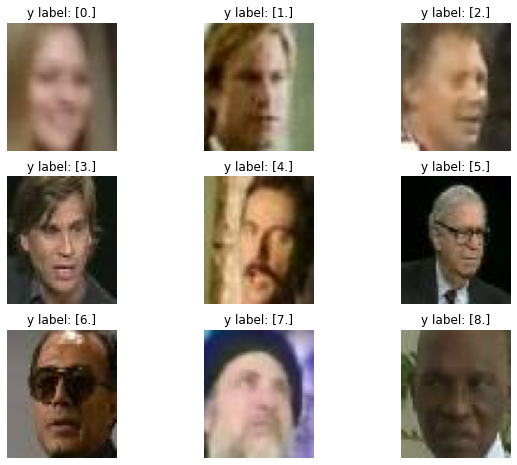

In [36]:
# Examples from cl_valid dataset
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.argwhere(y_cl_valid == i - 1)
  img, label = (x_cl_valid[index[0]], y_cl_valid[index[0]])
  figure.add_subplot(rows, cols, i)
  plt.title("y label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

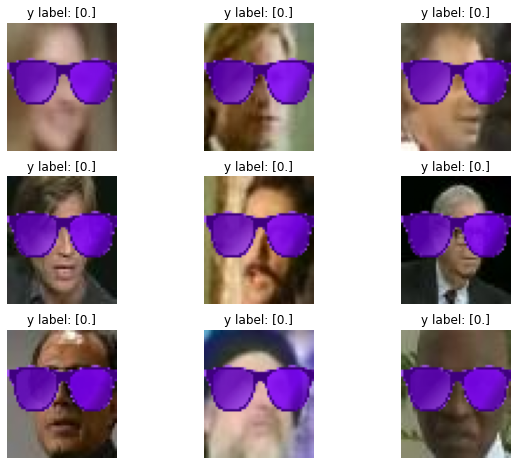

In [37]:
# Examples from bd_valid dataset
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.argwhere(y_cl_valid == i - 1)
  img, label = (x_bd_valid[index[0]], y_bd_valid[index[0]])
  figure.add_subplot(rows, cols, i)
  plt.title("y label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

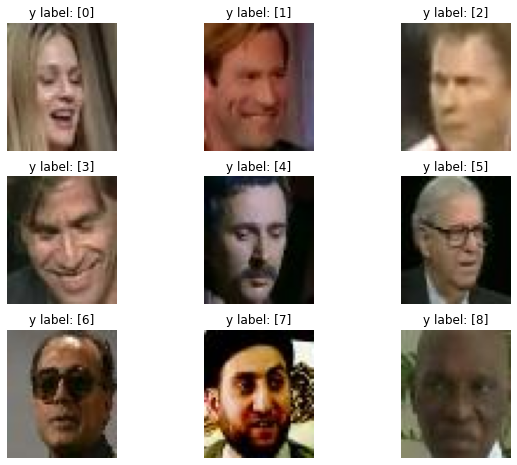

In [38]:
# Examples from cl_test dataset
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.argwhere(y_cl_test == i - 1)
  img, label = (x_cl_test[index[0]], y_cl_test[index[0]])
  figure.add_subplot(rows, cols, i)
  plt.title("y label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

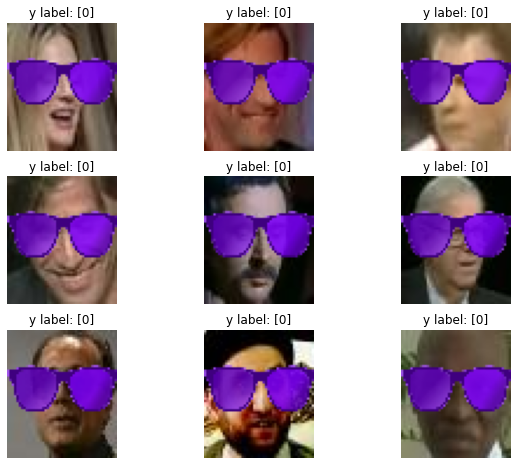

In [40]:
# Examples from bd_test dataset
figure = plt.figure(figsize=(10,8))
cols, rows = 3,3
for i in range(1, cols*rows+1):
  index = np.argwhere(y_cl_test == i - 1)
  img, label = (x_bd_test[index[0]], y_bd_test[index[0]])
  figure.add_subplot(rows, cols, i)
  plt.title("y label: {}".format(label))
  plt.axis("off")
  plt.imshow(img[0]/255)
plt.show()

Conclusions from data and examples above:

*   The clean and labelled dataset has 1283 classes, validation dataset has 9 samples for each class, and test dataset has 10 samples for each class. 
*   The each sample in bd dataset is transformed from cl dataset by adding sunglasses to each image, all of them will activates the backdoor for backdoored network. The backdoored network will classified all of them to class 0.
*   The idea of lab is to use pruning defense to prune the channels in increasing order of their average activation values to create a new model B' which will have the ability to classify images with sunglasses to any other classes other than 0 and try our best to keep the clean classification accuraccy as large as possible.


## Create new model B' and G using the pruning defense

In [10]:
# Design the G model
class GoodNet_Model(keras.Model):
  def __init__(self, BadNet, BadNet_prime):
    super(GoodNet_Model, self).__init__()
    self.BadNet = BadNet
    self.BadNet_prime = BadNet_prime

  def predict(self, dataset):
    y = np.argmax(self.BadNet(dataset), axis=1)
    y_prime = np.argmax(self.BadNet_prime(dataset), axis=1)
    pred = []
    for i in range(dataset.shape[0]):
      if y[i]==y_prime[i]:
        pred.append(y[i])
      else:
        pred.append(1283)
    return pred

In [11]:
# Clone the BadNet for pruning
BadNet_prime = keras.models.clone_model(BadNet)
BadNet_prime.set_weights(BadNet.get_weights())

In [12]:
# Sort the average activation values in decreasing order and get the channel indexes of them
pooling_layer_output = BadNet.get_layer('pool_3').output
# Cut off the model and make predictions for calculating average activation values
cutoff_model=keras.models.Model(inputs=BadNet.input,outputs=pooling_layer_output)
cutoff_predict = cutoff_model.predict(x_cl_valid)
print(cutoff_model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 55, 47, 3)]       0         
                                                                 
 conv_1 (Conv2D)             (None, 52, 44, 20)        980       
                                                                 
 pool_1 (MaxPooling2D)       (None, 26, 22, 20)        0         
                                                                 
 conv_2 (Conv2D)             (None, 24, 20, 40)        7240      
                                                                 
 pool_2 (MaxPooling2D)       (None, 12, 10, 40)        0         
                                                                 
 conv_3 (Conv2D)             (None, 10, 8, 60)         21660     
                                                                 
 pool_3 (MaxPooling2D)       (None, 5, 4, 60)          0     

In [13]:
# calculate the average activation values and sort their channel indexes from small to large
average_activation_values = np.mean(cutoff_predict, axis=(0,1,2))
print("The average activation values before sorting:")
print(average_activation_values)
# Sort the average activation values in increasing order
sorted_index = np.argsort(average_activation_values)
print("The average activation values after sorting:")
print(average_activation_values[sorted_index])
print("The channel indexes sorting according to average activation values: ")
print(sorted_index)

The average activation values before sorting:
[0.0000000e+00 8.5787827e-01 0.0000000e+00 5.3079766e-01 5.1451387e+00
 2.0289593e+00 6.2408652e-03 5.3690352e+00 2.1106052e+00 0.0000000e+00
 4.1488919e+00 2.1980383e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.5654893e+00 0.0000000e+00 5.0868425e+00 2.4381560e-01
 1.8378238e-01 8.3539158e-02 4.3979712e-02 3.0290736e-03 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 4.8440866e+00 1.0589786e+00
 0.0000000e+00 0.0000000e+00 1.5006671e-02 0.0000000e+00 0.0000000e+00
 4.8648095e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.7658595e-01 4.2763174e-01 0.0000000e+00
 0.0000000e+00 1.8540380e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.3321568e-02 6.2038713e+00 0.0000000e+00 3.6191165e+00
 0.0000000e+00 1.6352931e+00 8.2229853e+00 5.0732869e-01 0.0000000e+00]
The average activation values after sorting:
[0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00

In [44]:
# Origin clean_classification_accuracy
clean_classification_accuracy = 98.64899974019225
# Prepare lists for data saving
clean_classification_acc = []
attack_success_rate = []
# Create flags for saving the models only once
save_2_model_flag = False
save_4_model_flag = False
save_10_model_flag = False
save_30_model_flag = False
# As "pool_3" layer do not have parameters for us to prune, we will get "conv_3" layer's weight for pruning
weights_conv3 = BadNet.get_layer('conv_3').get_weights()[0]
bias_conv3 = BadNet.get_layer('conv_3').get_weights()[1]

# Pruning defense according to valid dataset, evaluate model using test dataset, and save data for ploting
for index, channel_index in enumerate(sorted_index):
  start_time = time.perf_counter()
  # Pruning the channel by setting its weights to 0
  weights_conv3[:,:,:,channel_index] = 0
  bias_conv3[channel_index] = 0
  BadNet_prime.get_layer('conv_3').set_weights([weights_conv3, bias_conv3])
  # Combine B and B' to G model
  GoodNet = GoodNet_Model(BadNet, BadNet_prime)
  # Copy the code in eval.py for calculation and evaluation
  # Calculate clear acc using valid dataset for saving model
  cl_valid_pred = np.argmax(BadNet_prime.predict(x_cl_valid), axis = 1)
  cl_valid_acc = np.mean(np.equal(cl_valid_pred, y_cl_valid))*100
  # Calculate the clear acc using test dataset for ploting
  cl_test_pred = GoodNet.predict(x_cl_test)
  cl_test_acc = np.mean(np.equal(cl_test_pred, y_cl_test))*100
  clean_classification_acc.append(cl_test_acc)
  # Calculate the attack success rate using test dataset for ploting
  bd_test_pred = GoodNet.predict(x_bd_test)
  asr = np.mean(np.equal(bd_test_pred, y_bd_test))*100
  attack_success_rate.append(asr)
  stop_time = time.perf_counter()
  # Paint data
  print("The %d/%d time of pruning: "%((index+1), len(sorted_index)))
  print("The pruning channel index is: %d"%channel_index)
  print("The clean classification accuracy is: %f"%cl_test_acc)
  print("The attack success rate is: %f"%asr)
  print("The costing time: %f"%(stop_time - start_time))
  # Saving B' model for evaluation
  if clean_classification_accuracy - cl_valid_acc >= 2 and save_2_model_flag == False:
    print("The accuracy drops at least 2%, saving B' model")
    BadNet_prime.save('MLSecurity-Lab3/lab3/models/bd_net_prime_2.h5')
    save_2_model_flag = True
  if clean_classification_accuracy - cl_valid_acc >= 4 and save_4_model_flag == False:
    print("The accuracy drops at least 4%, saving B' model")
    BadNet_prime.save('MLSecurity-Lab3/lab3/models/bd_net_prime_4.h5')
    save_4_model_flag = True
  if clean_classification_accuracy - cl_valid_acc >= 10 and save_10_model_flag == False:
    print("The accuracy drops at least 10%, saving B' model")
    BadNet_prime.save('MLSecurity-Lab3/lab3/models/bd_net_prime_10.h5')
    save_10_model_flag = True
  if clean_classification_accuracy - cl_valid_acc >= 30 and save_30_model_flag == False:
    print("The accuracy drops at least 30%, saving B' model")
    BadNet_prime.save('MLSecurity-Lab3/lab3/models/bd_net_prime_30.h5')
    save_30_model_flag = True 
  keras.backend.clear_session()

The 1/60 time of pruning: 
The pruning channel index is: 0
The clean classification accuracy is: 98.620421
The attack success rate is: 100.000000
The costing time: 3.648601
The 2/60 time of pruning: 
The pruning channel index is: 26
The clean classification accuracy is: 98.620421
The attack success rate is: 100.000000
The costing time: 2.945307
The 3/60 time of pruning: 
The pruning channel index is: 27
The clean classification accuracy is: 98.620421
The attack success rate is: 100.000000
The costing time: 2.995059
The 4/60 time of pruning: 
The pruning channel index is: 30
The clean classification accuracy is: 98.620421
The attack success rate is: 100.000000
The costing time: 3.081186
The 5/60 time of pruning: 
The pruning channel index is: 31
The clean classification accuracy is: 98.620421
The attack success rate is: 100.000000
The costing time: 2.905513
The 6/60 time of pruning: 
The pruning channel index is: 33
The clean classification accuracy is: 98.620421
The attack success rate

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


The 46/60 time of pruning: 
The pruning channel index is: 16
The clean classification accuracy is: 95.346843
The attack success rate is: 99.976617
The costing time: 2.873150
The 47/60 time of pruning: 
The pruning channel index is: 56
The clean classification accuracy is: 94.902572
The attack success rate is: 99.984412
The costing time: 2.922548
The 48/60 time of pruning: 
The pruning channel index is: 46
The clean classification accuracy is: 92.127825
The attack success rate is: 99.984412
The costing time: 2.865678
The accuracy drops at least 4%, saving B' model
The 49/60 time of pruning: 
The pruning channel index is: 5
The clean classification accuracy is: 91.582229
The attack success rate is: 99.984412
The costing time: 2.857418
The 50/60 time of pruning: 
The pruning channel index is: 8
The clean classification accuracy is: 91.130164
The attack success rate is: 99.976617
The costing time: 2.834128
The 51/60 time of pruning: 
The pruning channel index is: 11
The clean classificatio

## Evaluate Repaired networks for X={2%,4%,10%}

Using eval.py to evaluate repaired networks for X=2%

In [4]:
!python3 MLSecurity-Lab3/lab3/eval.py MLSecurity-Lab3/lab3/data/cl/test.h5 MLSecurity-Lab3/lab3/data/bd/bd_test.h5 MLSecurity-Lab3/lab3/models/bd_net_prime_2.h5

2021-12-16 01:00:06.377722: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Clean Classification accuracy: 95.90023382696803
Attack Success Rate: 100.0


Using eval.py to evaluate repaired networks for X=4%

In [5]:
!python3 MLSecurity-Lab3/lab3/eval.py MLSecurity-Lab3/lab3/data/cl/test.h5 MLSecurity-Lab3/lab3/data/bd/bd_test.h5 MLSecurity-Lab3/lab3/models/bd_net_prime_4.h5

2021-12-16 01:00:28.059246: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Clean Classification accuracy: 92.29150428682775
Attack Success Rate: 99.98441153546376


Using eval.py to evaluate repaired networks for X=10%

In [6]:
!python3 MLSecurity-Lab3/lab3/eval.py MLSecurity-Lab3/lab3/data/cl/test.h5 MLSecurity-Lab3/lab3/data/bd/bd_test.h5 MLSecurity-Lab3/lab3/models/bd_net_prime_10.h5

2021-12-16 01:00:41.339635: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Clean Classification accuracy: 84.54403741231489
Attack Success Rate: 77.20966484801247


Using eval.py to evaluate repaired networks for X=30%

In [4]:
!python3 MLSecurity-Lab3/lab3/eval.py MLSecurity-Lab3/lab3/data/cl/test.h5 MLSecurity-Lab3/lab3/data/bd/bd_test.h5 MLSecurity-Lab3/lab3/models/bd_net_prime_30.h5

2021-12-16 03:58:12.710547: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
Clean Classification accuracy: 54.762275915822286
Attack Success Rate: 6.96024941543258


Plot the accuracy on clean test data and the attack success rate (on backdoored test
data) as a function of the fraction of channels pruned.

Text(0.5, 1.0, 'clean classification accuracy and attack success rate for test dataset using G model')

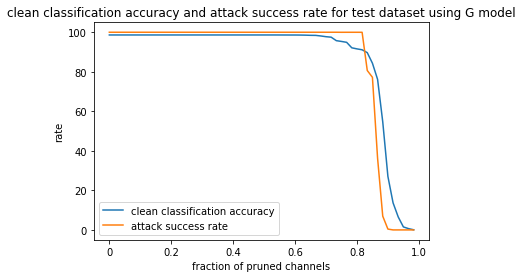

In [43]:
plt.plot(clean_classification_acc)
plt.plot(attack_success_rate)
plt.xticks([0,12,24,36,48,60],[0,0.2,0.4,0.6,0.8,1.0])
plt.legend(['clean classification accuracy','attack success rate'])
plt.xlabel("fraction of pruned channels")
plt.ylabel("rate")
plt.title("clean classification accuracy and attack success rate for test dataset using G model")

We can see in the plot above that though the G model can get the result which has zero attack success rate and non-zero clean classification accuracy, the result is not really successful. When the attack success rate decrease to zero, the clean classification accuracy is dropping over 50%. We can see from above that the clean classification accuracy begins to drop before the the attack success rate begins to drop which means that the reason of getting this result may be the bd_net we get is attacked using pruning aware attack. 